##### Working with AIA, XRT and NuSTAR data in python to get the DEM via regularisation

- 28-07-2022 IGH Based off axn_sep2020_new
  - Testing some things


In [1]:
# Import some of the stuff we might need

# This needs nustar_pysolar to be installed https://github.com/NuSTAR/nustar_pysolar
import nustar_pysolar as nustar

# This is from nustar_sac https://github.com/ianan/nustar_sac/blob/master/python/ns_tresp.py
import ns_tresp

from sys import path as sys_path
# Change to your local copy's location...
sys_path.append('/Users/iain/github/demreg/python')
from dn2dem_pos import dn2dem_pos

# Need aiapy to be installed https://gitlab.com/LMSAL_HUB/aia_hub/aiapy
from aiapy.calibrate import degradation
from aiapy.calibrate.util import get_correction_table
from aiapy.calibrate import register, update_pointing

import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
from pylab import figure, cm
import scipy.io as io
import glob
import astropy.time
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
import sunpy.map

import warnings
warnings.simplefilter('ignore')
matplotlib.rcParams['font.size'] = 16

---
#### Now for the XRT stuff

In [2]:
# Load in the XRT data and grade map for the Sep 2020 data from sswidl make_xrt_for_python.pro

fdata='XRT_20200912_204028_Be_thin_Open_512.fits'
fgm='gm_XRT_20200912_204028_Be_thin_Open_512.fits'

xmap=sunpy.map.Map(fdata)
xgmmap=sunpy.map.Map(fgm)

# # Submap closer to the region of interest
# bl=[-940*u.arcsec, 170*u.arcsec]
# tr=[-840*u.arcsec, 270*u.arcsec]
# bottom_left = SkyCoord(bl[0],bl[1], frame = xmap.coordinate_frame)
# top_right = SkyCoord(tr[0],tr[1], frame=xmap.coordinate_frame)
# sxmap = xmap.submap(bottom_left=bottom_left, top_right=top_right)

#  Get the XRT for just the region of interest
bl=[-890*u.arcsec, 219*u.arcsec]
tr=[-880*u.arcsec, 225*u.arcsec]
bottom_left = SkyCoord(bl[0],bl[1], frame = xmap.coordinate_frame)
top_right = SkyCoord(tr[0],tr[1], frame=xmap.coordinate_frame)
regxmap = xmap.submap(bottom_left=bottom_left, top_right=top_right)

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


In [3]:
#  What is the DN/s/px from the region???
dur=regxmap.exposure_time.value
# What pixel binning per dimension
chipsum=regxmap.meta['chip_sum']
#  Get a DN/s/px (non-binned pixels) for the region
xdnspx=np.mean(regxmap.data)/dur/chipsum**2
print(xdnspx, ' DN/s/px')

3.60276666469872  DN/s/px


In [4]:
#  Load in the XRT ones from sswidl make_xrt_tresp_forpy.pro
tr_sep20=io.readsav('xrt_tresp_20200912.dat')

filters=np.array(tr_sep20['filters'])
filters[0]=filters[0].decode('utf-8')
filters[1]=filters[1].decode('utf-8')
units=tr_sep20['units'].decode('utf-8')

---
#### Now for the AIA stuff

In [5]:
# #  Now prep and get the AIA values
# #  Do all the prep first and save out the submaps
# ffa=sorted(glob.glob('aia.lev1*.fits'))
# # print(ffa)

# amaps=sunpy.map.Map(ffa)
# # Get the wavelengths of the maps, get index of sort for this list of maps and reorder
# wvn0 = [m.meta['wavelnth'] for m in amaps]
# srt_id = sorted(range(len(wvn0)), key=wvn0.__getitem__)
# amaps = [amaps[i] for i in srt_id]
# print([m.meta['wavelnth'] for m in amaps])

# # aiaprep the images, may take a while to run
# aprep=[]
# for m in amaps:
#     m_temp = update_pointing(m)
#     aprep.append(register(m_temp))
# #  Just save out the prepped submaps to quickly load in later
# for m in aprep:
#     bottom_left = SkyCoord(-940*u.arcsec,170*u.arcsec, frame=m.coordinate_frame)
#     top_right = SkyCoord(-840*u.arcsec,270*u.arcsec, frame=m.coordinate_frame)
#     mm = m.submap(bottom_left=bottom_left, top_right=top_right)
#     wvn="{0:d}".format(1000+mm.meta['wavelnth'])
#     wvn=wvn[1:]
#     mm.save('maps_prep_092021_'+wvn+'.fits',overwrite='True')

In [6]:
ffp=sorted(glob.glob('maps_prep_092021*.fits'))
aprep=sunpy.map.Map(ffp)

In [7]:
# Get the durations for the DN/px/s normalisation and
# wavenlength to check the order - should already be sorted above
wvn = [m.meta['wavelnth'] for m in aprep]
durs = [m.meta['exptime'] for m in aprep]
# Convert to numpy arrays as make things easier later
durs=np.array(durs)
wvn=np.array(wvn)
print(durs)
print(wvn)

[2.902044 2.901345 2.000162 1.999637 2.90119  2.900818]
[ 94 131 171 193 211 335]


In [8]:
# Use the XRT region from above
# This is just a rough example so will need to refine these - got the correct AIA feature?
bl=[-890*u.arcsec, 219*u.arcsec]
tr=[-880*u.arcsec, 225*u.arcsec]

area=(tr[0].value-bl[0].value)*(tr[1].value-bl[1].value)*7.25e7*7.25e7  
print(area)

data_mean = []
num_pix = []
for m in aprep:
    bottom_left = SkyCoord(bl[0],bl[1], frame = m.coordinate_frame)
    top_right = SkyCoord(tr[0],tr[1], frame=m.coordinate_frame)
    sub_temp = m.submap(bottom_left=bottom_left, top_right=top_right)
    data_mean.append(np.mean(sub_temp.data))
    num_pix.append(sub_temp.data.size)
#     sub_temp.plot()
#     plt.show()
print(data_mean)

3.15375e+17
[5.67683, 36.71543781719263, 677.2892247243025, 568.7694418455856, 239.07170412209274, 6.793778390941739]


In [9]:
# Let's get the degradation correction factors
channels = [94,131,171,193,211,335] * u.angstrom
time=astropy.time.Time('2020-09-12T20:40:00', scale='utc')

# nc=len(channels)
# degs=np.empty(nc)
# for i in np.arange(nc):
#       degs[i]=degradation(channels[i],time)#,calibration_version=10)
# print(degs)

# As slow to compute here's the previously calculated for the above
degs=np.array([0.90317732, 0.50719532, 0.73993289, 0.49304311, 0.40223458, 0.17221724])
print(degs)

[0.90317732 0.50719532 0.73993289 0.49304311 0.40223458 0.17221724]


In [10]:
#  Correct the AIA data for the degradation
cor_data=data_mean/degs
print(data_mean)
print(cor_data)

# Get into DN/s/px for the DEM stuff
adn_in=cor_data/durs
print('DN/s/px: ',adn_in)

[5.67683, 36.71543781719263, 677.2892247243025, 568.7694418455856, 239.07170412209274, 6.793778390941739]
[   6.28539899   72.38914944  915.33872041 1153.58967666  594.35890401
   39.44888671]
DN/s/px:  [  2.16585241  24.95020394 457.63229199 576.8995456  204.86727998
  13.59922846]


In [11]:
#  Load in the AIA responses from sswidl make_aiaresp_forpy.pro
trin=io.readsav('aia_tresp_en.dat')

for i in np.arange(len(trin['channels'])):
    trin['channels'][i]=trin['channels'][i].decode("utf-8")
# print(trin['channels'])
chans=np.array(trin['channels'])

# Get the temperature response functions in the correct form for demreg
tresp_logt=np.array(trin['logt'])
nt=len(tresp_logt)
nf=len(trin['tr'][:])
trmatrix=np.zeros((nt,7))
for i in range(0,nf):
    trmatrix[:,i]=trin['tr'][i]

---
#### Combine the XRT and AIA together

In [12]:
#  Now combine the AIA and XRT data together
dn_in=np.append(adn_in,xdnspx)
# Lets just assume 20% error
edn_in=0.2*np.copy(dn_in)
chanax=np.append(chans,filters[1])

for i in np.arange(len(dn_in)):
    print(chanax[i],': ',dn_in[i],edn_in[i])

xrtint=10**np.interp(tresp_logt,tr_sep20['logt'],np.log10(tr_sep20['tr'][1]))
trmatrix[:,6]=xrtint


A94 :  2.165852409540008 0.43317048190800156
A131 :  24.950203938111002 4.990040787622201
A171 :  457.6322919909902 91.52645839819805
A193 :  576.8995455987884 115.3799091197577
A211 :  204.86727998026595 40.97345599605319
A335 :  13.599228463801257 2.7198456927602517
Be-thin :  3.60276666469872 0.720553332939744


---
#### Now for the NuSTAR stuff

In [13]:
# Now add in the NuSTAR
# Should be from nu80610208001 obsid

# Just load in the ect to check everything is as expected
dirin='/Users/iain/Downloads/sep2020__smallflares_spec/80610208001/event_cl/'
# Think this is the correct CHU state for the small flare time
infile = 'nu80610208001B06_chu12_N_cl_sunpos.evt'

# Load in the evt
hdulist = fits.open(dirin+infile)
evtdata=hdulist[1].data
hdr = hdulist[1].header
hdulist.close()

In [14]:
# # Make and plot the full CHU map, and one filtered to just the time of small flares
# nustar_map = nustar.map.make_sunpy(evtdata, hdr,norm_map=True)

# bl = SkyCoord(-1500*u.arcsec, -500*u.arcsec, frame=nustar_map.coordinate_frame)
# tr = SkyCoord(-500*u.arcsec, 500*u.arcsec, frame=nustar_map.coordinate_frame)
# nustar_submap = nustar_map.submap(bottom_left=bl,top_right=tr)

# dmin=1e-3
# dmax=1e-1


# fig = plt.figure(figsize=(7, 7))
# nustar_submap.plot(norm=colors.LogNorm(vmin=dmin,vmax=dmax),cmap=cm.get_cmap('Spectral_r'))
# coords = SkyCoord(Tx=(-1000, -900)*u.arcsec,Ty=(200,300)*u.arcsec,frame=nustar_submap.coordinate_frame)
# nustar_submap.draw_quadrangle(coords,edgecolor="black",\
#                               linestyle="--",linewidth=2,label='2-element SkyCoord')
# plt.colorbar()
# plt.show()


# # Now filter the evt file to remove bad pixels (default) and part of the time
# time_range=astropy.time.Time(['2020-09-12T20:39:00', '2020-09-12T20:45:00'], format='isot')
# dtim=time_range[1]-time_range[0]
# cleanevt = nustar.filter.event_filter(evtdata,fpm='B',energy_low=1.6, energy_high=10,\
#                                      hdr=hdr,time_range=time_range)

# # Need to manually correct the livetime, though barely changing over whole evt so can just use
# # whole evt livetime range 
# lvtfrac=hdr['livetime']/hdr['ontime']

# filter_map = nustar.map.make_sunpy(cleanevt, hdr,on_time=dtim.sec ,exp_time=dtim.sec*lvtfrac,norm_map=True)
# bl = SkyCoord(-1500*u.arcsec, -500*u.arcsec, frame=filter_map.coordinate_frame)
# tr = SkyCoord(-500*u.arcsec, 500*u.arcsec, frame=filter_map.coordinate_frame)
# filter_submap = filter_map.submap(bottom_left=bl,top_right=tr)
# fig = plt.figure(figsize=(7, 7))
# filter_submap.plot(norm=colors.Normalize(vmin=1e-3,vmax=1e-2),cmap=cm.get_cmap('Spectral_r'))
# coords = SkyCoord(Tx=(-1000, -900)*u.arcsec,Ty=(200,300)*u.arcsec,frame=filter_submap.coordinate_frame)
# filter_submap.draw_quadrangle(coords,edgecolor="white",\
#                               linestyle="--",linewidth=2,label='2-element SkyCoord')
# plt.colorbar()
# plt.show()

In [15]:
# For test just using Sarah's pha,arf,rmf for FPMB and 20:39 to 20:45 -> though other options available
# Load in the pha, arf and rmf
# Using examples from https://github.com/KriSun95/krispy/blob/master/krispy/nu_spec.py
mdir=dirin+'spec_2039_2045/'
fnsid='nu80610208001B06_chu12_N'

e_lo, e_hi, eff_area = ns_tresp.read_arf(mdir+fnsid+'_sr.arf')
e_lo, e_hi, rmf_mat = ns_tresp.read_rmf(mdir+fnsid+'_sr.rmf')

In [16]:
# Load in the saved output from f_vth()
# dlogT = 0.05 and dE = 0.04 keV 
#So binning size is the same as in AIA 0.05 
fvth=io.readsav('fvth_out.dat')
engs=fvth['eng']
de=engs[1]-engs[0]
logt=fvth['logt']
phmod=np.array(fvth['fvth']) # in units of photons/s/keV/cm2

nume=len(engs)
arf=eff_area[:nume]
rmf=rmf_mat[0:nume,0:nume]
srm = np.array([rmf[r, :] * arf[r] for r in range(len(arf))])
n1,n2=phmod.shape
modrs= np.zeros([n1,n2])
for t in np.arange(n2):
    modrs[:,t]=(phmod[:,t]@srm)*de
    
eng_tr=[2.5,4]
tresp=np.zeros([len(modrs[0,:]),len(eng_tr)-1])

for i in np.arange(len(eng_tr)-1):
    gd=np.where((e_lo >= eng_tr[i]) & (e_hi < eng_tr[i+1]) )
    mm=np.sum(modrs[gd,:],axis=1)
    tresp[:,i]=mm[0,:]/1e49
intp_ntresp=10**np.interp(tresp_logt,logt,np.log10(tresp[:,0]*area))

In [17]:
# Now just need to load in the pha
engs,cnts,lvtm,ontim=ns_tresp.read_pha(mdir+fnsid+'_sr.pha')

# Work out the total count rate and error in the energy bands
rate=np.zeros(len(eng_tr)-1)
erate=np.zeros(len(eng_tr)-1)
               
for i in np.arange(len(eng_tr)-1):
    gd=np.where((engs >= eng_tr[i]) & (engs < eng_tr[i+1]) )
    rate[i]=np.sum(cnts[gd])/lvtm
    erate[i]=np.sqrt(np.sum(cnts[gd]))/lvtm
print(rate)
print(erate)
print('Error [%]:', 100.*erate/rate)

[0.21995472]
[0.02628962]
Error [%]: [11.95228609]


---
#### Combine all together and calculate/plot things...

In [18]:
fin_tresp=np.zeros([len(tresp_logt),8])
fin_tresp[:,:-1]=trmatrix
fin_tresp[:,7]=intp_ntresp

chans=np.concatenate((chanax, ['N2.5-4keV']), axis=0)
fin_dn=np.concatenate((dn_in, rate), axis=0)
fin_edn=np.concatenate((0.2*dn_in, (erate**2+(0.2*rate)**2)**0.5), axis=0)

for i in np.arange(len(fin_dn)):
    print(chans[i],':    ',"{0:.2f}".format(fin_dn[i]),"  {0:.2f}".format(fin_edn[i]),"  {0:.0f}".format(100*fin_edn[i]/fin_dn[i]),'%')

A94 :     2.17   0.43   20 %
A131 :     24.95   4.99   20 %
A171 :     457.63   91.53   20 %
A193 :     576.90   115.38   20 %
A211 :     204.87   40.97   20 %
A335 :     13.60   2.72   20 %
Be-thin :     3.60   0.72   20 %
N2.5-4keV :     0.22   0.05   23 %


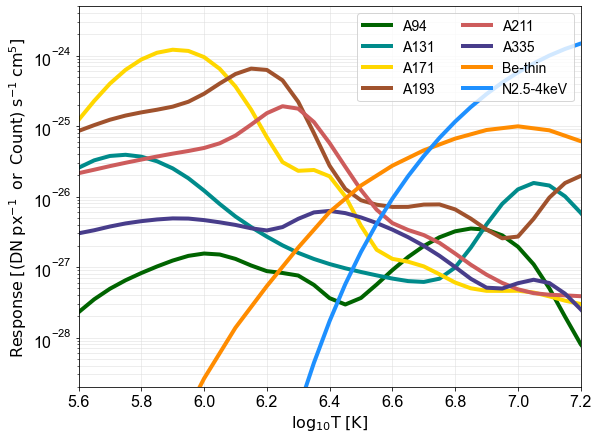

In [19]:
# Plot all the temperature responses
# Setup some colours
clrs=['darkgreen','darkcyan','gold','sienna','indianred','darkslateblue','darkorange','dodgerblue']

# Do the plot
fig = plt.figure(figsize=(9, 7))
plt.rcParams.update({'font.size': 16,'font.family':"sans-serif",\
                     'font.sans-serif':"Arial",'mathtext.default':"regular"})
for i in np.arange(8):
    plt.semilogy(tresp_logt,fin_tresp[:,i],label=chans[i],color=clrs[i],lw=4)
plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
plt.ylabel('$\mathrm{Response\;[(DN\;px^{-1}\;\;or\;\;Count)\;s^{-1}\;cm^5]}$')
plt.ylim([2e-29,5e-24])
plt.xlim([5.6,7.2])
plt.legend(ncol=2,prop={'size': 14})
plt.rcParams.update({'font.size': 16})
plt.grid(True,which='both',lw=0.5,color='gainsboro')
plt.show()

In [20]:
# # Finally plot the EM Loci
# plt.rcParams.update({'font.size': 16,'font.family':"sans-serif",\
#                      'font.sans-serif':"Arial",'mathtext.default':"regular"})
# fig = plt.figure(figsize=(8, 6))
# for i in np.arange(8):
#     plt.semilogy(tresp_logt,fin_dn[i]/fin_tresp[:,i],label=chans[i],color=clrs[i],lw=4)
# plt.ylim([1e23,1e29])
# plt.xlim([5.6,7.2])
# plt.xlabel('Temperature [K]')
# plt.ylabel('$Emission\;Measure\;[cm^{-5}]$')
# plt.legend(ncol=2,prop={'size': 14})
# plt.grid(True,which='both',lw=0.5,color='gainsboro')
# fig.show()

---
#### Compare AIA vs AIA+XRT vs AIA+XRT+NuSTAR

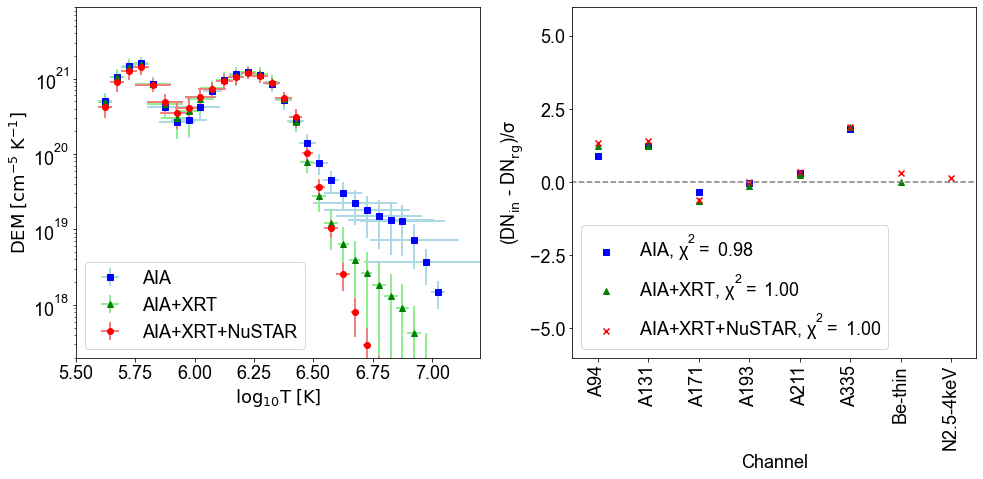

In [21]:
#####################################
# Do up to 7.0 as stable and that should cover everything possible
mint=5.6
maxt=7.0
dlogt=0.05
temps70=10**np.arange(mint,maxt+dlogt,dlogt)
mlogt70=([np.mean([(np.log10(temps70[i])),np.log10((temps70[i+1]))]) \
        for i in np.arange(0,len(temps70)-1)])

dem70axn,edem70axn,elogt70axn,chisq70axn,dn_reg70axn\
    =dn2dem_pos(fin_dn,fin_edn,fin_tresp,tresp_logt,temps70,gloci=1,emd_int=True)
dem70ax,edem70ax,elogt70ax,chisq70ax,dn_reg70ax\
    =dn2dem_pos(fin_dn[0:7],fin_edn[0:7],fin_tresp[:,0:7],tresp_logt,temps70,gloci=1,emd_int=True)
#most optimal way of running AIA alone? emloci start not recommended as no sharp responses, so gloci=0.
dem70a,edem70a,elogt70a,chisq70a,dn_reg70a\
    =dn2dem_pos(fin_dn[0:6],fin_edn[0:6],fin_tresp[:,0:6],tresp_logt,temps70,gloci=0,emd_int=True) 
        
#####################################

fig = plt.figure(figsize=(14, 7))
plt.rcParams.update({'font.size': 18})
ax1 = fig.add_subplot(1, 2,1)
plt.errorbar(mlogt70,dem70a,xerr=elogt70a,yerr=edem70a,fmt='sb',\
             ecolor='lightblue', elinewidth=2, capsize=0,label='AIA')
plt.errorbar(mlogt70,dem70ax,xerr=elogt70ax,yerr=edem70ax,fmt='^g',\
             ecolor='lightgreen', elinewidth=2, capsize=0,label='AIA+XRT')
plt.errorbar(mlogt70,dem70axn,xerr=elogt70axn,yerr=edem70axn,fmt='or',\
             ecolor='lightcoral', elinewidth=2, capsize=0,label='AIA+XRT+NuSTAR')
plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
plt.ylabel('$\mathrm{DEM\;[cm^{-5}\;K^{-1}]}$')
plt.ylim([2e17,9e21])
plt.xlim([5.5,7.2])
plt.yscale('log')
plt.legend(loc=3)

ax2 = fig.add_subplot(1, 2,2)
plt.scatter(np.arange(6),(fin_dn[0:6]-dn_reg70a)/fin_edn[0:6],marker='s',color='blue',label='AIA, $\chi^2 =$ {:0.2f}'.format(chisq70a))
plt.scatter(np.arange(7),(fin_dn[0:7]-dn_reg70ax)/fin_edn[0:7],marker='^',color='green',label='AIA+XRT, $\chi^2 =$ {:0.2f}'.format(chisq70ax))
plt.scatter(np.arange(8),(fin_dn-dn_reg70axn)/fin_edn,marker='x',color='red',label='AIA+XRT+NuSTAR, $\chi^2 =$ {:0.2f}'.format(chisq70axn))
plt.plot([-1,12],[0,0],'--',color='grey')
plt.ylim([-6,6])
plt.xlim([-0.5,7.5])
plt.xticks(np.arange(8),chans,rotation=90)
plt.xlabel('Channel')
plt.ylabel('(DN$_\mathrm{in}$ - DN$_\mathrm{rg}$)/$\sigma}$')
plt.locator_params(axis='y', nbins=5)
plt.tight_layout()
plt.legend()
plt.show()


In [22]:
# # Check what T the emission from NuSTAR is coming from:
# nt=len(dem70axn)

# # First work out dT, so in non-log space
# dt70=temps70[1:]-temps70[0:-1]
# #  Get the response in correct units and same T binning as DEM
# nstint1=10**np.interp(mlogt70,tresp_logt,np.log10(fin_tresp[:,7])) * dt70

# # Then contribution per T bin is
# ns_cntrb1=[dem70axn[i]*nstint1[i] for i in range(nt)]
# # Total of this should be, basically, the same as the DEM_REG value for that channel
# print(np.sum(ns_cntrb1),dn_reg70axn[7])

# fig = plt.figure(figsize=(7, 5))
# plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
# plt.ylabel('Contrib Frac')
# # plt.ylim([2e16,9e21])
# plt.xlim([5.5,7.2])
# plt.plot(mlogt70,ns_cntrb1/np.sum(ns_cntrb1),label=chans[7],lw=3)
# plt.rcParams.update({'font.size': 16})
# plt.legend()
# plt.show()



A94 DN_in: 2.166, DN_rg:1.593, Sm:1.593
A131 DN_in: 24.950, DN_rg:17.863, Sm:17.873
A171 DN_in: 457.632, DN_rg:512.583, Sm:512.866
A193 DN_in: 576.900, DN_rg:574.735, Sm:575.053
A211 DN_in: 204.867, DN_rg:190.260, Sm:190.365
A335 DN_in: 13.599, DN_rg:8.448, Sm:8.452
Be-thin DN_in: 3.603, DN_rg:3.372, Sm:3.374
N2.5-4keV DN_in: 0.220, DN_rg:0.213, Sm:0.213


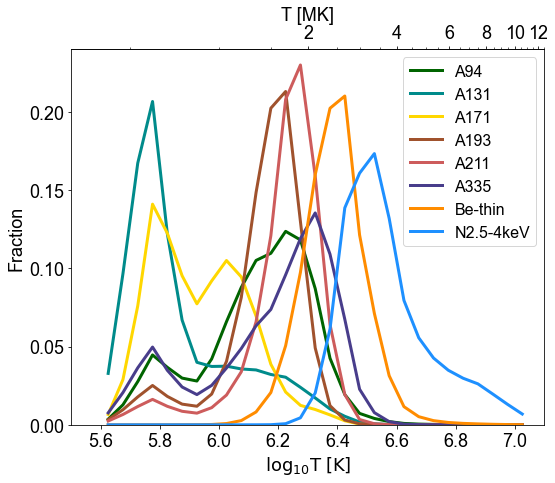

In [23]:
#  Do for all channels to see what T emission coming from
nt=len(dem70axn)

# First work out dT, so in non-log space
dt70=temps70[1:]-temps70[0:-1]

fig,ax = plt.subplots(figsize=(8, 7))
plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
plt.ylabel('Fraction')
plt.xlim([5.5,7.1])
plt.ylim([0,.24])
for i in range(len(chans)):
    # Need to interpolate Tresp onto T binning of DEM, and and dt to get units correct
    # DEM is 1/cm^5/K and resp is data cm^5/s
    tr_int_temp=10**np.interp(mlogt70,tresp_logt,np.log10(fin_tresp[:,i])) * dt70
    cntrb_temp=[dem70axn[tt]*tr_int_temp[tt] for tt in range(nt)]
    print(chans[i],"DN_in: {0:.3f}, DN_rg:{1:.3f}, Sm:{2:.3f}".format(fin_dn[i],dn_reg70axn[i],np.sum(cntrb_temp)))
    plt.plot(mlogt70,cntrb_temp/np.sum(cntrb_temp),label=chans[i],color=clrs[i],lw=3)

# Functions for plotting a second axis but in MK not logT
def forward(x):
    return (10**x)*1e-6
def inverse(x):
    return np.log10(x*1e6)
secax = ax.secondary_xaxis('top', functions=(forward, inverse))
from matplotlib.ticker import (
    AutoLocator, AutoMinorLocator)
secax.xaxis.set_minor_locator(AutoMinorLocator())
secax.set_xlabel('T [MK]')

plt.rcParams.update({'font.size': 16})
plt.tight_layout()
plt.legend()
plt.show()


A94 DN_in: 2.166, DN_rg:1.778, Sm:1.778
A131 DN_in: 24.950, DN_rg:18.804, Sm:18.814
A171 DN_in: 457.632, DN_rg:488.563, Sm:488.833
A193 DN_in: 576.900, DN_rg:581.568, Sm:581.889
A211 DN_in: 204.867, DN_rg:191.852, Sm:191.958
A335 DN_in: 13.599, DN_rg:8.644, Sm:8.649


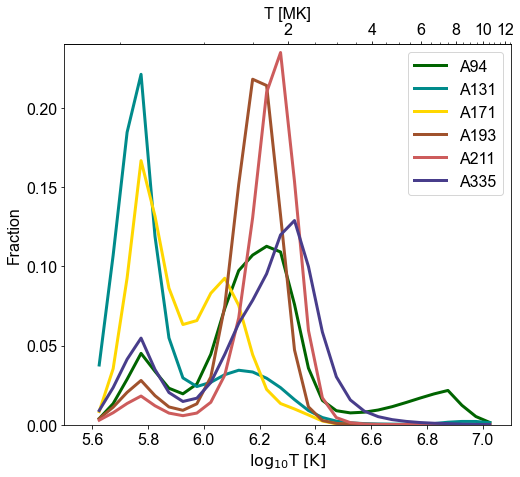

In [24]:
#  Repear but using just the AIA only DEM
nt=len(dem70a)

# First work out dT, so in non-log space
dt70=temps70[1:]-temps70[0:-1]

fig,ax = plt.subplots(figsize=(8, 7))
plt.xlabel('$\mathrm{\log_{10}T\;[K]}$')
plt.ylabel('Fraction')
plt.xlim([5.5,7.1])
plt.ylim([0,.24])
for i in range(6):
    # Need to interpolate Tresp onto T binning of DEM, and and dt to get units correct
    # DEM is 1/cm^5/K and resp is data cm^5/s
    tr_int_temp=10**np.interp(mlogt70,tresp_logt,np.log10(fin_tresp[:,i])) * dt70
    cntrb_temp=[dem70a[tt]*tr_int_temp[tt] for tt in range(nt)]
    print(chans[i],"DN_in: {0:.3f}, DN_rg:{1:.3f}, Sm:{2:.3f}".format(fin_dn[i],dn_reg70a[i],np.sum(cntrb_temp)))
    plt.plot(mlogt70,cntrb_temp/np.sum(cntrb_temp),label=chans[i],color=clrs[i],lw=3)

# Functions for plotting a second axis but in MK not logT
def forward(x):
    return (10**x)*1e-6
def inverse(x):
    return np.log10(x*1e6)
secax = ax.secondary_xaxis('top', functions=(forward, inverse))
from matplotlib.ticker import (
    AutoLocator, AutoMinorLocator)
secax.xaxis.set_minor_locator(AutoMinorLocator())
secax.set_xlabel('T [MK]')

plt.rcParams.update({'font.size': 16})
plt.legend()
plt.show()
